In [1]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# DICL
from dicl import dicl, adapters
from dicl.icl import iclearner as icl
from dicl.utils.main_script import (
    load_moment_model,
)

from dicl.utils.main_script import prepare_data

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

# Visualize predicted trajectories

In [3]:
dataset = "ETTh1"
n_components = 7
forecasting_horizon = 96
context_length = 512
is_fine_tuned = "ft"
model_name = "AutonLab/MOMENT-1-small"

df = pd.DataFrame()
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name=f"{dataset}_pred={forecasting_horizon}",
    context_length=context_length,
    forecasting_horizon=forecasting_horizon,
)
time_series = np.concatenate([X_test, y_test], axis=-1)
adapter_list = [
    None,
    "dropoutLinearAE",
    "VAE",
]
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda:0"

pred_dict = {adapter: {"mean": [], "lb": [], "ub": []} for adapter in adapter_list}
for adapter in adapter_list:
    n_components = n_features
    model_loaded = False
    if not model_loaded:
        model_loaded = True
        model = load_moment_model(model_name, forecasting_horizon).to(
            torch.device(device)
        )
        icl_constructor = icl.MomentICLTrainer

    disentangler = adapters.MultichannelProjector(
        num_channels=n_features,
        new_num_channels=n_components,
        patch_window_size=None,
        base_projector=adapter,
        device=device,
    )

    iclearner = icl_constructor(
        model=model,
        n_features=n_components,
        forecast_horizon=forecasting_horizon,
    )

    DICL = dicl.DICL(
        disentangler=disentangler,
        iclearner=iclearner,
        n_features=n_features,
        n_components=n_components,
        pca_in_preprocessing=False,
    )
    if adapter not in [None, "pca"]:
        log_dir = Path("/mnt/vdb/abenechehab/dicl-adapters/logs/notebooks")
        log_dir = log_dir / f"toy-synthetic_{adapter}_{model_name}"
        log_dir = log_dir / f"n_comp={n_components}"
        log_dir = log_dir / f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_seed={seed}"
        os.makedirs(log_dir, exist_ok=True)

        # assert not args.is_fine_tuned, "iclearner must be frozen when adapter is "
        # "(supervised) fine-tuned"
        DICL.fine_tune_iclearner(
            X=X_train,
            y=y_train,
            X_val=X_train,
            y_val=y_train,
            batch_size=32,
            learning_rate=1e-3,
            verbose=0,
            use_disentangler=False,
            n_epochs=50,
            seed=seed,
        )
        DICL.adapter_supervised_fine_tuning(
            X_train=X_train,
            y_train=y_train,
            X_val=X_train,
            y_val=y_train,
            device=device,
            log_dir=log_dir,
            verbose=1,
            n_epochs=100,
        )
    else:
        DICL.fine_tune_iclearner(
            X=X_train,
            y=y_train,
            X_val=X_train,
            y_val=y_train,
            batch_size=32,
            learning_rate=1e-3,
            verbose=0,
            use_disentangler=False,
            n_epochs=50,
            seed=seed,
        )
        DICL.fit_disentangler(X=X_test)

    mean, _, lb, ub = DICL.predict_multi_step(
        X=time_series,
        prediction_horizon=forecasting_horizon,
        batch_size=128,
    )
    pred_dict[adapter]["mean"].append(mean)
    pred_dict[adapter]["lb"].append(lb)
    pred_dict[adapter]["ub"].append(ub)

    metrics = DICL.compute_metrics(calibration=False)

    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [
                    {
                        "adapter": adapter,
                        "n_components": n_components,
                        "seed": seed,
                        **metrics,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/dicl-adapters/src/dicl/icl/iclearner.py:563: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 0:   0%|          | 0/252 [00:00<?, ?it/s]/mnt/vdb/abenechehab/dicl-adapters/src/dicl/icl/iclearner.py:582: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=Tr

Restoring weights from epoch 49


/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
feature: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise

Restoring weights from epoch 49


/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warn

Early stopping at epoch 23
Restoring weights from epoch 13



feature: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will rais

KeyboardInterrupt: 

In [8]:
pred_dict.keys()
pred_dict[None]["mean"][0].shape

(2785, 7, 96)

In [10]:
pred_dict["dropoutLinearAE"]["mean"][0].shape

(2785, 7, 96)

<Figure size 640x480 with 0 Axes>

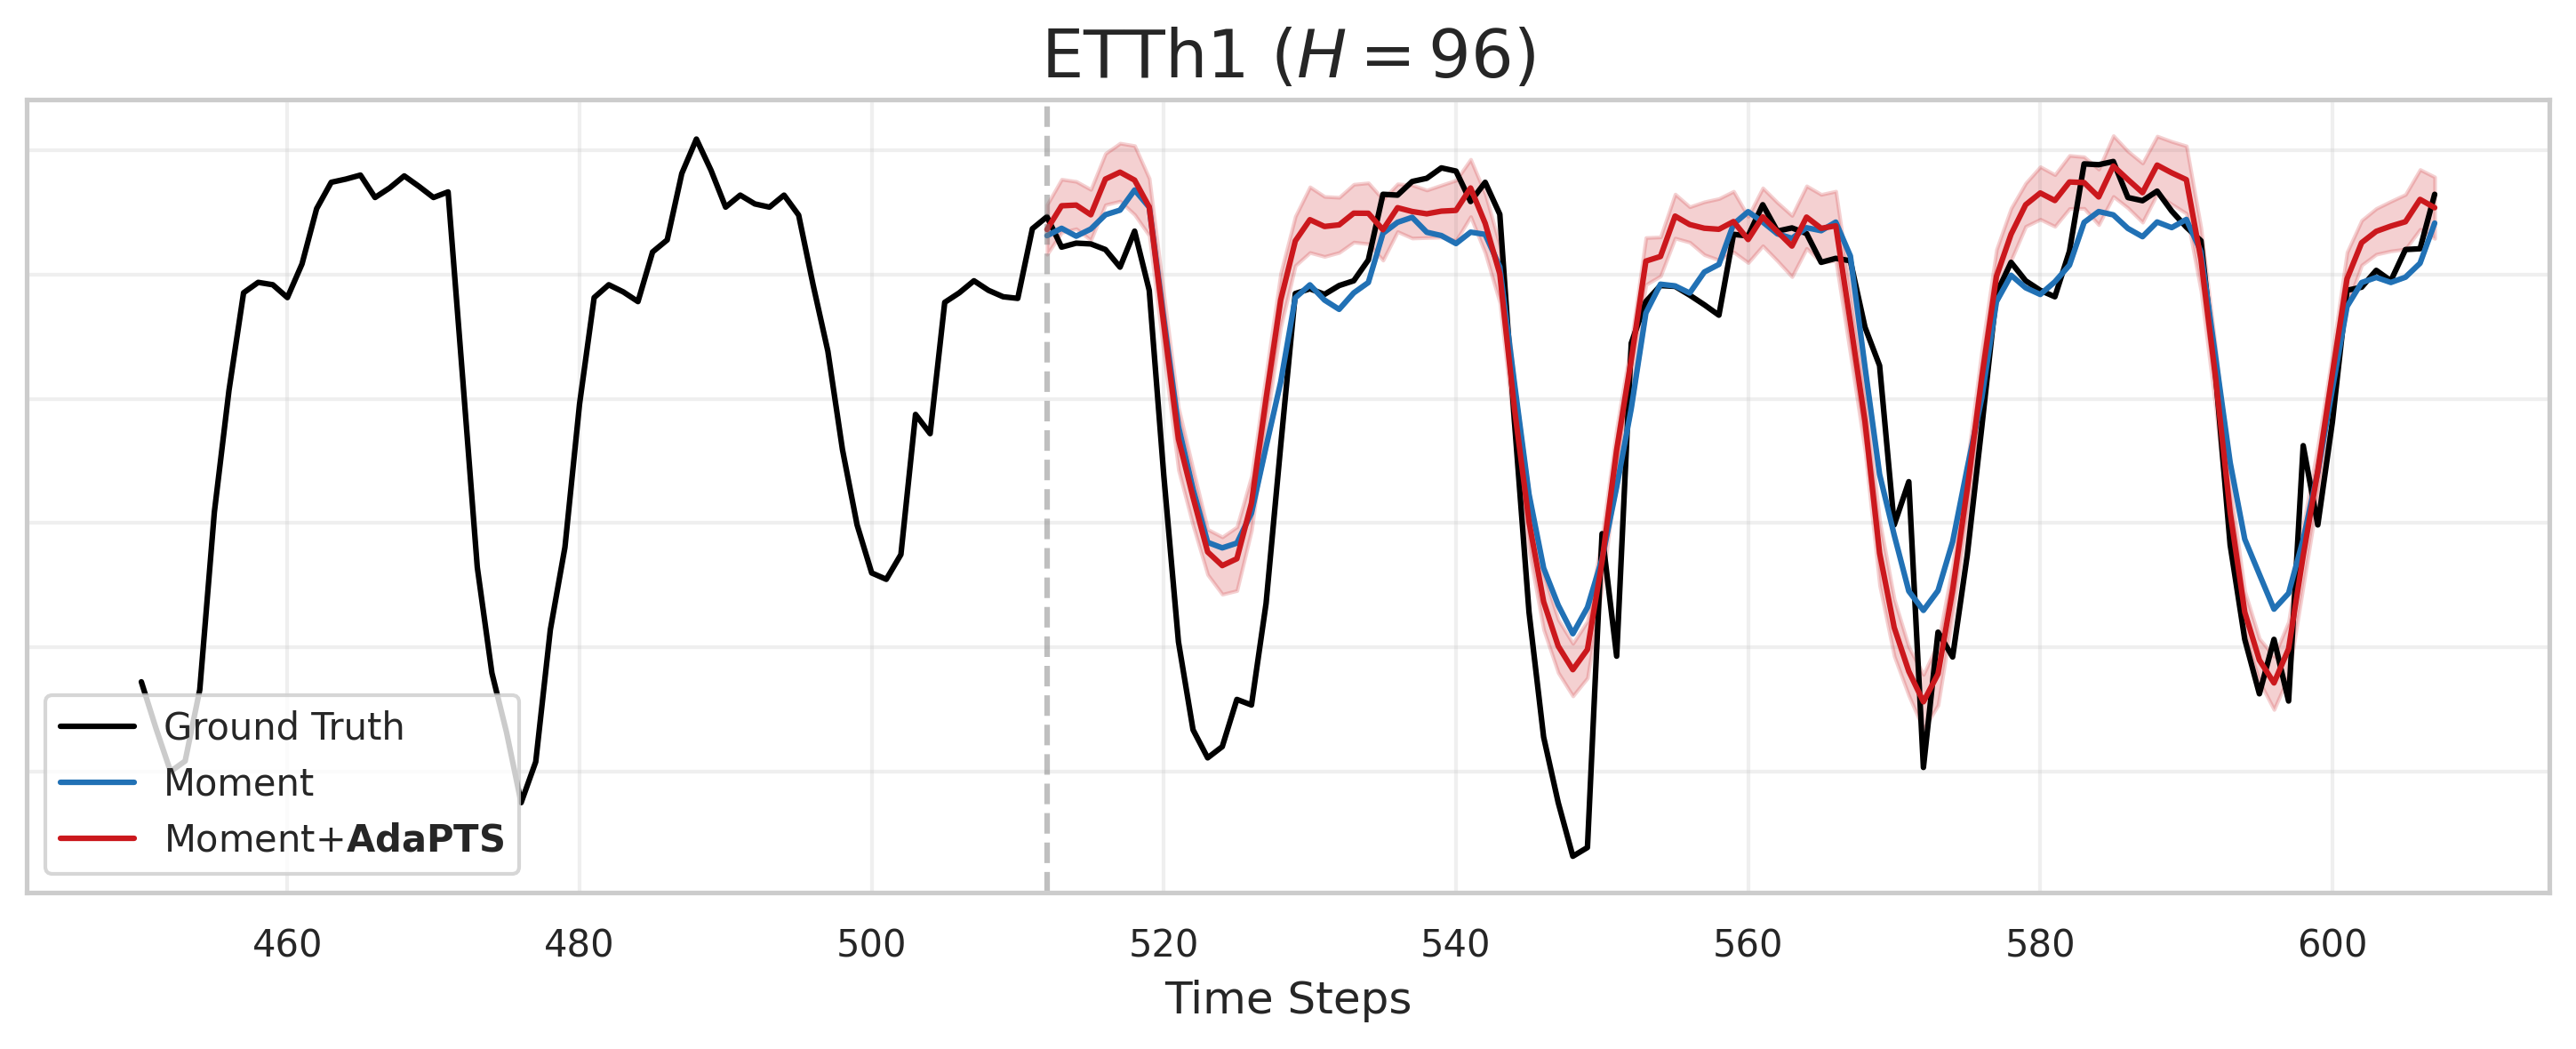

In [35]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

min_x = 450
sample_idx = 0
feature = 2  # Using single feature for clarity

# Plot actual time series
ax.plot(
    np.arange(min_x, context_length + forecasting_horizon),
    time_series[sample_idx, feature, min_x:],
    label="Ground Truth",
    color="black",
    linewidth=1.5,
)

# Plot predictions and confidence intervals
colors = {None: "#2171b5", "dropoutLinearAE": "#cb181d"}
labels = {None: "Moment", "dropoutLinearAE": r"Moment+$\mathbf{AdaPTS}$"}

for adapter in [None, "dropoutLinearAE"]:
    mean = pred_dict[adapter]["mean"][0][sample_idx, feature]
    lb = pred_dict[adapter]["lb"][0][sample_idx, feature]
    ub = pred_dict[adapter]["ub"][0][sample_idx, feature]

    # Plot mean prediction
    ax.plot(
        np.arange(context_length, context_length + forecasting_horizon),
        mean,
        label=f"{labels[adapter]}",
        color=colors[adapter],
        linewidth=1.5,
    )

    # Plot confidence intervals
    ax.fill_between(
        np.arange(context_length, context_length + forecasting_horizon),
        lb,
        ub,
        alpha=0.2,
        color=colors[adapter],
        # label=f'{labels[adapter]} 95% CI'
    )

# Add vertical line to separate context and prediction
ax.axvline(x=context_length, color="gray", linestyle="--", alpha=0.5)

# Customize plot
ax.set_xlabel("Time Steps", fontsize=12)
# ax.set_ylabel('Value', fontsize=12)
ax.set_yticklabels([])
ax.tick_params(axis="both", which="major", labelsize=10)

# Add legend with better placement
ax.legend(loc="lower left", frameon=True, fontsize=10)

# Add grid but make it lighter
ax.grid(True, alpha=0.3)

# Tight layout to prevent label clipping
plt.tight_layout()

ax.set_title(r"ETTh1 ($H=96$)")

# Save figure with high resolution
# plt.savefig('prediction_plot.pdf', bbox_inches='tight', dpi=300)
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/traj.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [36]:
import pickle

# Save using pickle since pred_dict contains numpy arrays and nested structures
save_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/pred_dict.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, "wb") as f:
    pickle.dump(pred_dict, f)

In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dicl.utils.main_script import prepare_data
from sklearn.decomposition import PCA

import torch

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

# Latent representations

Illness_pred=96, size: (69, 7, 512), val size (2, 7, 512), test size (98, 7, 512)
X_train_time: (582, 7)
X_test_time: (609, 7)


<Figure size 640x480 with 0 Axes>

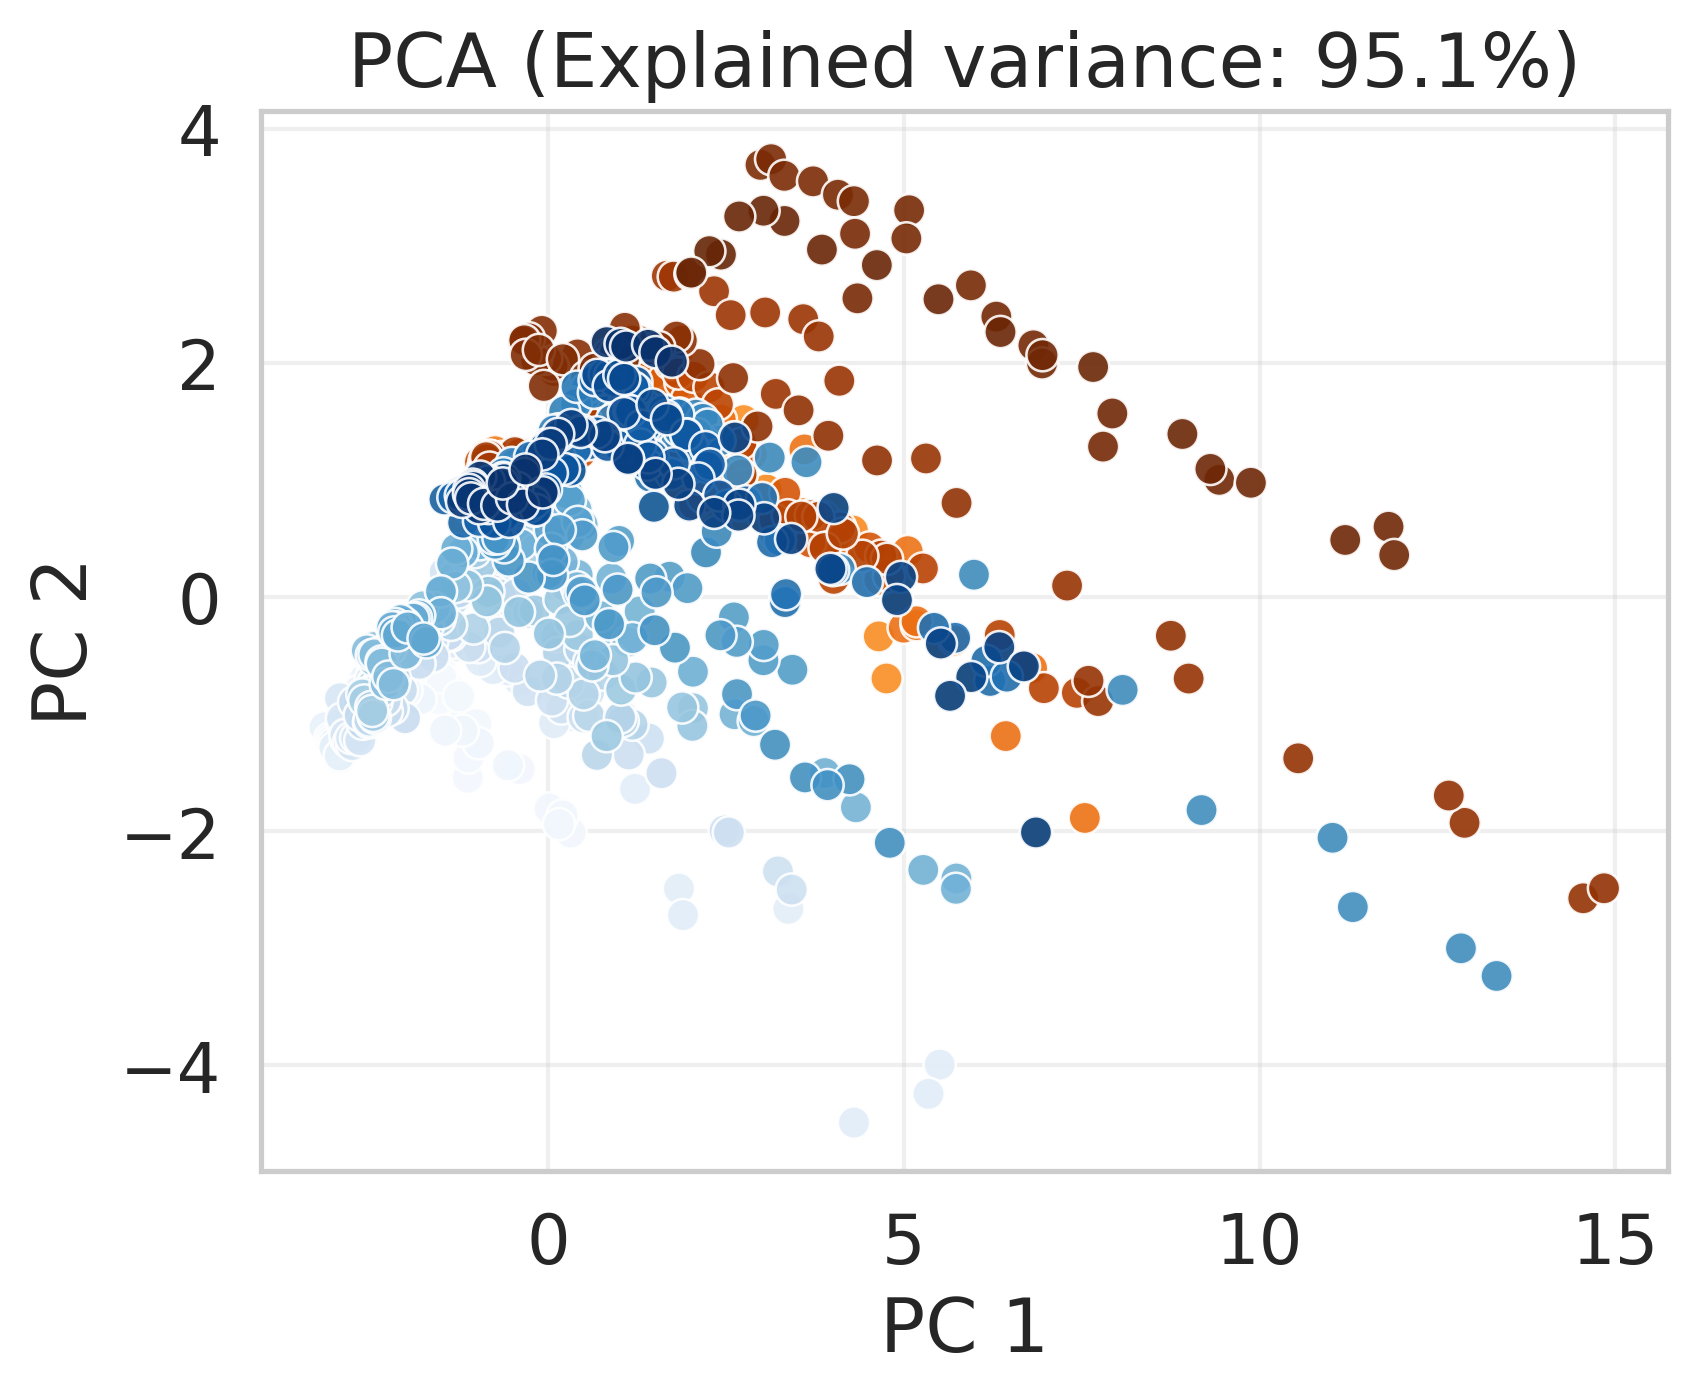

In [52]:
dataset_name = "Illness"
forecasting_horizon = 96
context_length = 512

X_train, _, X_val, _, X_test, _, n_features = prepare_data(
    dataset_name=f"{dataset_name}_pred={forecasting_horizon}",
    context_length=context_length,
    forecasting_horizon=forecasting_horizon,
)
print(
    f"{dataset_name}_pred={forecasting_horizon}, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

X_train = np.concatenate([X_train, X_val], axis=0)

X_train_time = X_train[0, :, :].copy()  # Get the last feature and reshape to 2D
for i in range(1, len(X_train)):
    X_train_time = np.concatenate(
        [X_train_time, X_train[i, :, -1].reshape(-1, 1)], axis=-1
    )
X_train_time = X_train_time.swapaxes(0, 1)

print(f"X_train_time: {X_train_time.shape}")

X_test_time = X_test[0, :, :].copy()  # Get the last feature and reshape to 2D
for i in range(1, len(X_test)):
    X_test_time = np.concatenate(
        [X_test_time, X_test[i, :, -1].reshape(-1, 1)], axis=-1
    )
X_test_time = X_test_time.swapaxes(0, 1)

print(f"X_test_time: {X_test_time.shape}")

# Apply PCA to X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_time)
X_test_pca = pca.transform(X_test_time)

# Compute the amount of explained variance by PCA
explained_variance = pca.explained_variance_ratio_

# Prepare data for plotting
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["time"] = np.arange(X_pca.shape[0])

X_test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
X_test_pca_df["time"] = np.arange(X_test_pca.shape[0])


# Set style parameters for scientific paper
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

# Create figure
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=300)

# Plot test data
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.9,
    s=60,
    ax=ax1,
    legend=False,
)

# Plot training data
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.9,
    s=60,
    ax=ax1,
    legend=False,
)


# Add custom legend
blue_color = sns.color_palette("Blues", n_colors=10)[5]
orange_color = sns.color_palette("YlOrBr", n_colors=10)[5]
ax1.scatter([], [], c=[blue_color], alpha=0.6, s=40, label="Training")
ax1.scatter([], [], c=[orange_color], alpha=0.6, s=40, label="Test")

# Customize plot
ax1.set_title(f"PCA (Explained variance: {sum(explained_variance)*100:.1f}%)")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
# ax1.legend(bbox_to_anchor=(0.5, -0.25), loc="upper center", ncol=2)

ax1.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(
    f"/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/repr_pca_{dataset_name}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

/tmp/ipykernel_3315045/1101754650.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapter = torch.load(adapter_path)


X_pca: (71, 2, 512)
X_train_time: (582, 2)


<Figure size 640x480 with 0 Axes>

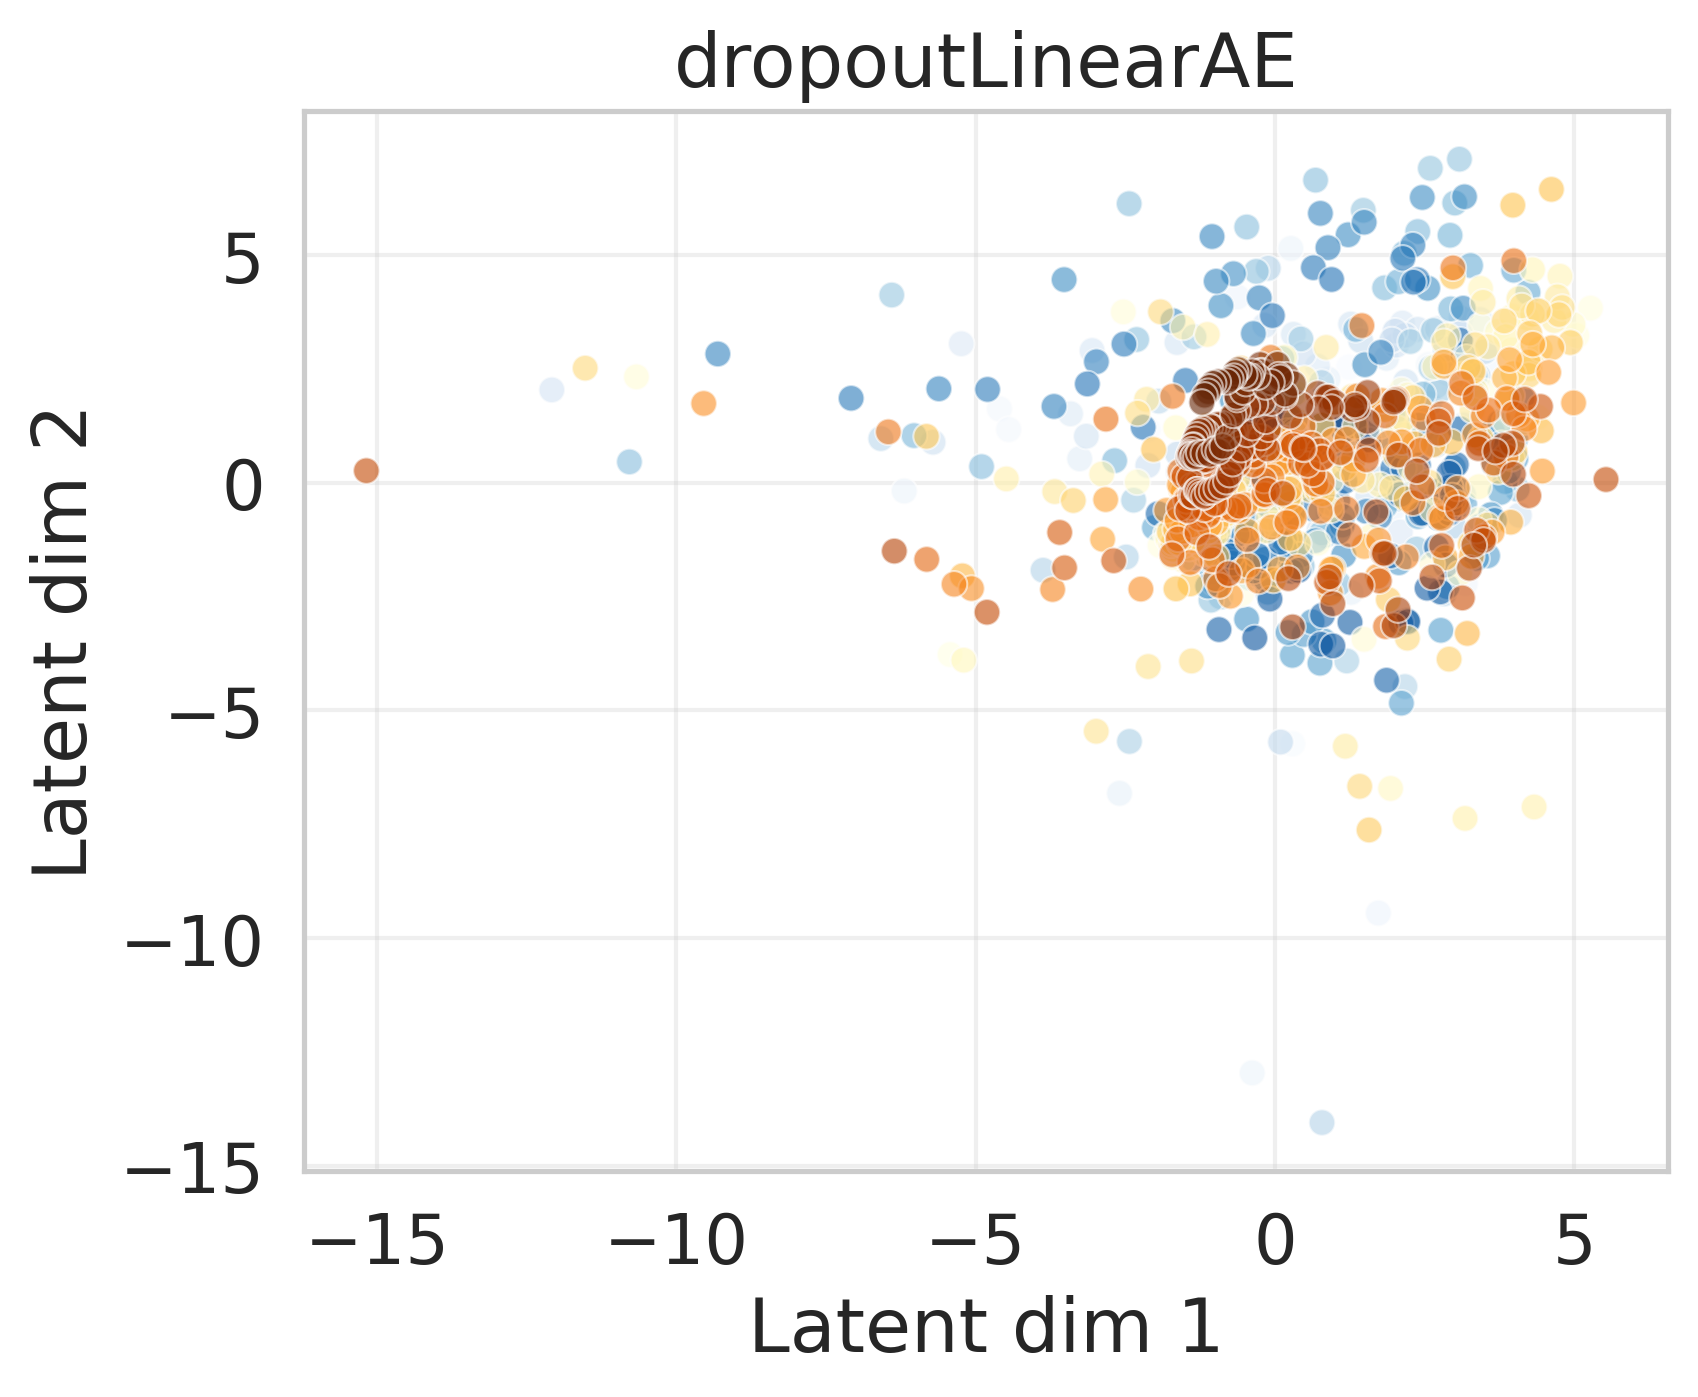

In [47]:
# adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/logger/Illness_pred=24/20250127_021352_Illness_pred=24_VAE_MOMENT-1-small/n_comp_2/adapter.pt"
# ETTh1 VAE
# adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/ETTh1_pred=96/20250129_110148_ETTh1_pred=96_VAE_MOMENT-1-small/n_comp_2/adapter.pt"
# Illnes VAE
# adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250129_111343_Illness_pred=24_VAE_MOMENT-1-small/n_comp_2/adapter.pt"
# Illness linearVAE
# adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250129_111443_Illness_pred=24_linearVAE_MOMENT-1-small/n_comp_2/adapter.pt"
# Illness dropoutLinearAE
adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250129_011135_Illness_pred=24_dropoutLinearAE_MOMENT-1-small/n_comp_2/adapter.pt"


adapter = torch.load(adapter_path)

adapter_name = "dropoutLinearAE"

device = adapter.device

# Apply PCA to X
X_pca = (
    adapter.transform_torch(torch.from_numpy(X_train).float().to(device))
    .cpu()
    .detach()
    .numpy()
).reshape((-1, 2, context_length))
X_test_pca = (
    adapter.transform_torch(torch.from_numpy(X_test).float().to(device))
    .cpu()
    .detach()
    .numpy()
).reshape((-1, 2, context_length))

print(f"X_pca: {X_pca.shape}")

X_train_time = X_pca[0, :, :].copy()  # Get the last feature and reshape to 2D
for i in range(1, len(X_pca)):
    X_train_time = np.concatenate(
        [X_train_time, X_pca[i, :, -1].reshape(-1, 1)], axis=-1
    )
X_train_time = X_train_time.swapaxes(0, 1)

print(f"X_train_time: {X_train_time.shape}")

X_test_time = X_test_pca[0, :, :].copy()  # Get the last feature and reshape to 2D
for i in range(1, len(X_test_pca)):
    X_test_time = np.concatenate(
        [X_test_time, X_test_pca[i, :, -1].reshape(-1, 1)], axis=-1
    )
X_test_time = X_test_time.swapaxes(0, 1)

# Prepare data for plotting
X_pca_df = pd.DataFrame(X_train_time, columns=["PC1", "PC2"])
X_pca_df["time"] = np.arange(X_train_time.shape[0])

X_test_pca_df = pd.DataFrame(X_test_time, columns=["PC1", "PC2"])
X_test_pca_df["time"] = np.arange(X_test_time.shape[0])


# Set style parameters for scientific paper
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

# Create figure
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=300)

# Plot training data
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.6,
    s=40,
    ax=ax1,
    legend=False,
)

# Plot test data
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.6,
    s=40,
    ax=ax1,
    legend=False,
)

# Add custom legend
blue_color = sns.color_palette("Blues", n_colors=10)[5]
orange_color = sns.color_palette("YlOrBr", n_colors=10)[5]
ax1.scatter([], [], c=[blue_color], alpha=0.6, s=40, label="Training")
ax1.scatter([], [], c=[orange_color], alpha=0.6, s=40, label="Test")

# Customize plot
ax1.set_title(adapter_name)
ax1.set_xlabel("Latent dim 1")
ax1.set_ylabel("Latent dim 2")
# ax1.legend(bbox_to_anchor=(0.5, -0.25), loc="upper center", ncol=2)

ax1.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(
    f"/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/repr_pca_{dataset_name}_{adapter_name}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()